In [54]:
import re, math
import operator
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cross_validation import StratifiedShuffleSplit
from random import randint
import ipynb.fs.defs.PeopleInfo as peopleInfo
from nltk.corpus import stopwords
from nltk import TweetTokenizer
import ipynb.fs.defs.FilterMethods as filterMethods
import sys, os
sys.path.append('../2_feature')
import ipynb.fs.defs.GetFeatures as getFeatures
global stop_words
stop_words = stopwords.words('english')
import plotly
import plotly.plotly as py
import plotly.graph_objs as go
from IPython.display import display, Image
plotly.tools.set_credentials_file(username='Adeline', api_key='Z5eltNtBQXqvI05ZFQtz')

In [2]:
def replace_by_symbols(txt):
#     txt = re.sub(r"https\S+", 'URL', txt)
#     txt = re.sub(r"http\S+", 'URL', txt)
#     txt = re.sub(r"pic.twitter.com\S+", 'URL', txt)
#     txt = re.sub(r"twitter.com/\S+", 'URL', txt)
#     txt = re.sub(r"\S+/\S+", 'URL', txt)
#     txt = re.sub(r"@\S+", 'USERMENTION', txt)
#     txt = re.sub(r"#\S+", 'HASHTAG', txt)
    txt = re.sub(r"https\S+", '', txt)
    txt = re.sub(r"http\S+", '', txt)
    txt = re.sub(r"pic.twitter.com\S+", '', txt)
    txt = re.sub(r"twitter.com/\S+", '', txt)
    txt = re.sub(r"\S+/\S+", '', txt)
    txt = re.sub(r"@\S+", '', txt)
    txt = re.sub(r"#\S+", '', txt)
    txt = re.sub(r"&amp", '', txt)    # &amp: space
    txt = re.sub(r"idk", 'i do not know', txt)   # idk: i don't know
    txt = re.sub(r"tho", 'though', txt)   # tho
    txt = re.sub(r"i\'m", 'i am', txt)
    txt = re.sub(r"you\'re", 'you are', txt)
    txt = re.sub(r"he\'s", 'he is', txt)
    txt = re.sub(r"she\'s", 'she is', txt)
    txt = re.sub(r"it\'s", 'it is', txt)
    txt = re.sub(r"we\'re", 'we are', txt)
    txt = re.sub(r"they\'re", 'they are', txt)
    txt = re.sub(r"isn\'t", 'is not', txt)
    txt = re.sub(r"don\'t", 'do not', txt)
    txt = re.sub(r"doesn\'t", 'does not', txt)
    txt = re.sub(r"didn\'t", 'did not', txt)
    txt = re.sub(r"wasn\'t", 'was not', txt)
    txt = re.sub(r"weren\'t", 'were not', txt)
    txt = re.sub(r"can\'t", 'can not', txt)
    txt = re.sub(r"couldn\'t", 'could not', txt)
    txt = re.sub(r"wouldn\'t", 'would not', txt)
    txt = re.sub(r"shouldn\'t", 'should not', txt)
#     txt = re.sub(r"\S+\'ll", '{0} will'.format(txt[0:-3]), txt)
#     txt = re.sub(r"\S+\'ve", '{0} have'.format(txt[0:-3]), txt)
    return txt

In [3]:
patients = dict()
ordinarys = dict()
with open('../0_dataset/patient_ids') as r:
    for patient in r.readlines()[:100]:
        patient = patient.strip()
        patients[patient] = peopleInfo.Patient(patient)
with open('../0_dataset/ordinary_ids') as r:
    for ordinary in r.readlines()[:100]:
        ordinary = ordinary.strip()
        ordinarys[ordinary] = peopleInfo.Ordinary(ordinary)

In [5]:
patients = filterMethods.filter_user_by_tweet_number(patients)
ordinarys = filterMethods.filter_user_by_tweet_number(ordinarys)

Remove users:[]
Remove users:[]


In [6]:
base_texts = []
group_texts = []

for key in patients.keys():
    group_texts.append(replace_by_symbols('\n'.join(patients[key].getText())))

for key in ordinarys.keys():
    base_texts.append(replace_by_symbols('\n'.join(ordinarys[key].getText())))

corpus = base_texts + group_texts

# Functions

In [26]:
def getTopFeatures(vectorizer, classifier, k=50):
    vector2word = vectorizer.get_feature_names()
    feature_indicies = np.argsort(classifier.feature_importances_)
    top_words = []
    for i in range(k):
        vector = feature_indicies[-i-1]
        word = vector2word[vector]
        top_words.append(word)
    return top_words

In [8]:
def create_vectorizer():
    vectorizer = TfidfVectorizer(stop_words="english", token_pattern='(?u)\\b[a-zA-Z]\\w{2,}\\b', ngram_range = (1,1), min_df=1)
    return vectorizer

In [9]:
def display_scores(vectorizer, tfidf_result):
    # http://stackoverflow.com/questions/16078015/
    scores = zip(vectorizer.get_feature_names(),
                 np.asarray(tfidf_result.sum(axis=0)).ravel())
    sorted_scores = sorted(scores, key=lambda x: x[1], reverse=True)
    words = []
    scores = []
#     for item in sorted_scores[:100]:
#         print("{0:30}\tScore: {1}".format(item[0], item[1]))
    for item in sorted_scores:
        words.append(item[0])
        scores.append(item[1])
    return words, scores

# Tf-idf with Randomforest

In [27]:
vectorizer = TfidfVectorizer(stop_words="english", token_pattern='(?u)\\b[a-zA-Z]\\w{2,}\\b', ngram_range = (1,1), min_df=1)
X = vectorizer.fit_transform(corpus)
Y = np.array([0] * len(base_texts) + [1]*len(group_texts), dtype=int)
classifier  = RandomForestClassifier(n_jobs=-1, max_features="sqrt", n_estimators=128)
classifier.fit(X,Y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=128, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [28]:
top100 = getTopFeatures(vectorizer, classifier, k=100)

# Tf-idf without Randomforest

In [18]:
vectorizer_base = create_vectorizer()
tfidf_result_base = vectorizer_base.fit_transform(base_texts)
words_base, scores_base = display_scores(vectorizer_base, tfidf_result_base)

In [19]:
vectorizer_group = create_vectorizer()
tfidf_result_group = vectorizer_group.fit_transform(group_texts)
words_group, scores_group = display_scores(vectorizer_group, tfidf_result_group)

# Find correspond scores

In [31]:
with open('top100_correspond', 'w') as open_file:
    for top in top100:
        if top in words_base and top in words_group:
#             print('{0}\tBase\t{1}\tGroup\t{2}'.format(top,scores_base,scores_group))
            index_base = words_base.index(top)
            index_group = words_group.index(top)
            open_file.write('{0:20}\tBase\t{1}\tGroup\t{2}\n'.format(top,scores_base[index_base],scores_group[index_group]))
        elif top in words_base:
#             print('{0}\tBase\t{1}'.format(top,scores_base))
            index = words_base.index(top)
            open_file.write('{0:20}\tBase\t{1}\tGroup\t{2}\n'.format(top,scores_base[index],0))
        elif top in words_group:
#             print('{0}\tGroup\t{1}'.format(top,scores_group))
            index = words_group.index(top)
            open_file.write('{0:20}\tBase\t{1}\tGroup\t{2}\n'.format(top,0,scores_group[index]))
        else:
#             print('{0}\tNot found')
            open_file.write('{0:20}\tNot found\n')

# Visualization

In [49]:
with open('top100_correspond') as open_file:
    words,scores_b,scores_g = [],[],[]
    for line in open_file.readlines():
        eles = line.strip().split('\t')
#         print(eles)
        words.append(re.sub(' ', '', eles[0]))
        scores_b.append(eles[2])
        scores_g.append(eles[4])

In [113]:
percentages = []
for i in range(len(scores_b)):
    total = float(scores_b[i])+float(scores_g[i])
    diff = abs(float(scores_b[i])-float(scores_g[i]))
    percentages.append(round(diff/total,4))

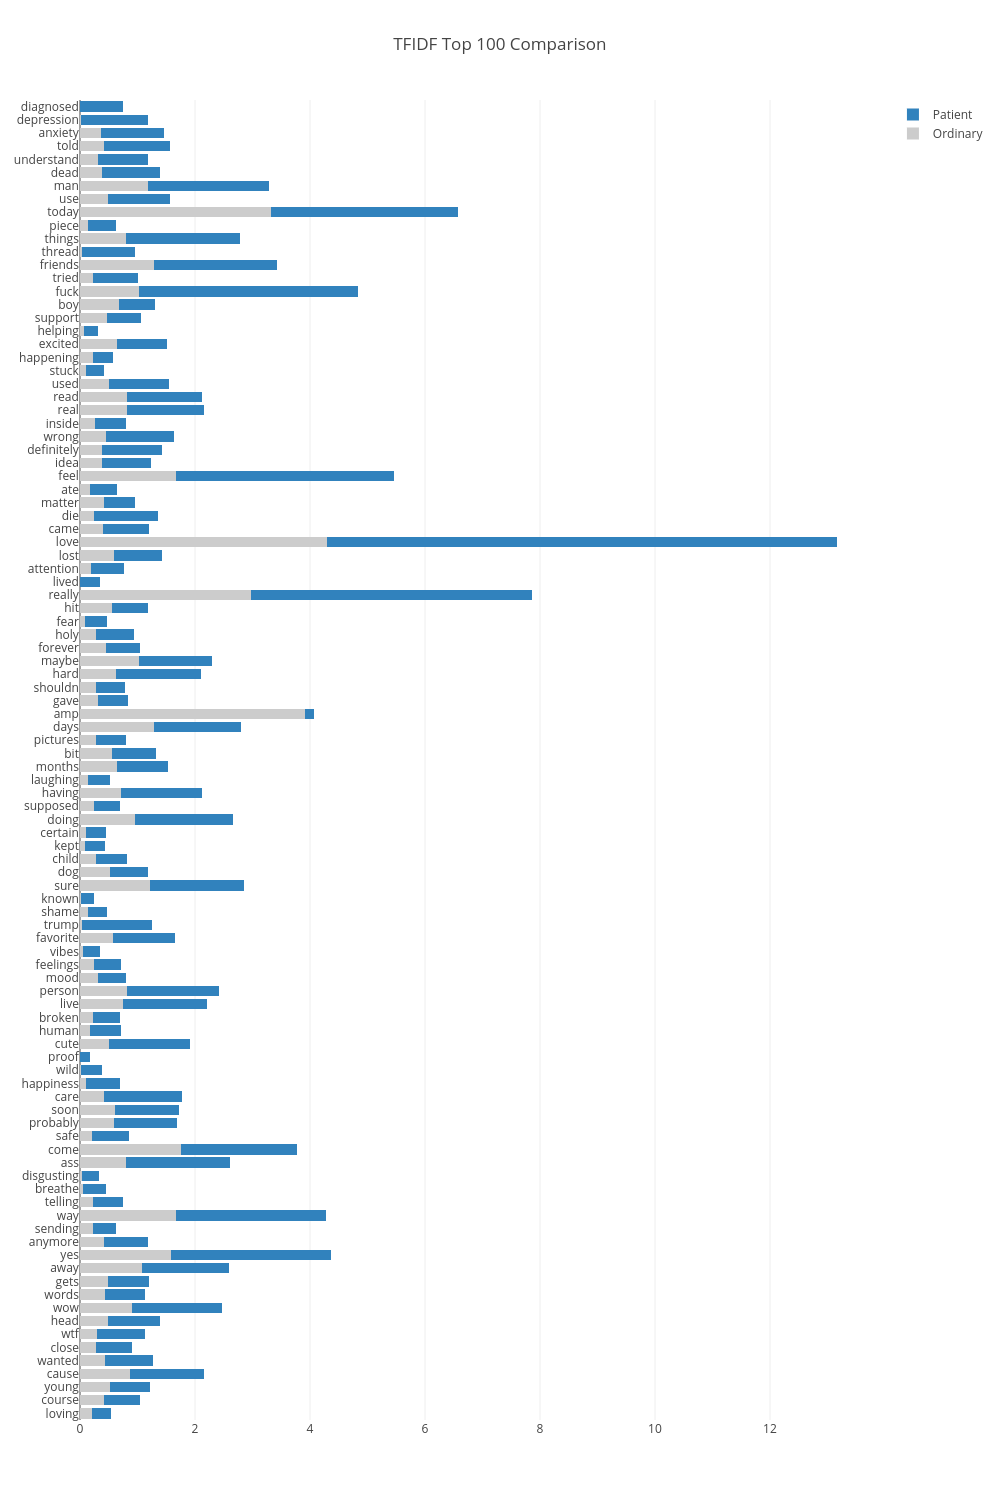

In [119]:
trace1 = go.Bar(
    x=scores_b[::-1],
    y=words[::-1],
    name='Ordinary',
    marker=dict(color='rgb(204,204,204)'),
    hoverinfo='none',
    orientation='h'
)
trace2 = go.Bar(
    x=scores_g[::-1],
    y=words[::-1],
    name='Patient',
    marker=dict(color='rgb(49,130,189)'),
    hoverinfo='none',
    orientation='h'
)
data = [trace1, trace2]
layout = go.Layout(
    title='TFIDF Top 100 Comparison',
    barmode='stack',
    autosize=False,
    width=1000,
    height=1500,
    yaxis=dict(
        dtick=1
    )
)
fig = go.Figure(data=data, layout=layout)
# py.iplot(fig, filename='tfidf')
py.image.save_as(fig, filename='img/tfidf.png')
display(Image(filename='img/tfidf.png'))

In [117]:
trace3 = go.Scatter(
    x=percentages[::-1],
    y=words[::-1],
    name='Difference',
    marker=dict(color='rgb(255, 0, 0)'),
    hoverinfo=percentages[::-1]
)
data = [trace3]
layout = go.Layout(
    title='TFIDF Top 100 Difference Comp'
    barmode='stack',
    autosize=False,
    width=500,
    height=1500,
    yaxis=dict(
        dtick=1
    ),
    shapes=[dict({
            'type': 'line',
            'x0': 0.5,
            'y0': 0,
            'x1': 0.5,
            'y1': 100,
            'line': {
                'color': 'rgb(50, 171, 96)',
                'width': 2,
                'dash': 'dashdot'
            }})]
)
fig = go.Figure(data=data, layout=layout)
# py.iplot(fig, filename='line')
py.image.save_as(fig, filename='img/tfidf_diff.png')
display(Image(filename='img/tfidf_diff.png'))